In [28]:
# Install + Imports
!pip -q install xgboost shap

import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore")

print(" Setup complete")


 Setup complete


In [29]:
# Load Data
DATA_PATH = "/content/sample_data/dengue_data_with_weather_data.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()


Shape: (900, 11)
Columns: ['Year', 'Province', 'District', 'Latitude', 'Longitude', 'Elevation', 'Month', 'Cases', 'Temp_avg', 'Precipitation_avg', 'Humidity_avg']


,Year,Province,District,Latitude,Longitude,Elevation,Month,Cases,Temp_avg,Precipitation_avg,Humidity_avg
0,2019,Western,Colombo,6.924429,79.90725,4,1,1225,26.914286,0.771429,72.607143
1,2019,Western,Gampaha,7.065026,79.96622,19,1,724,27.417857,0.728571,69.892857
2,2019,Western,Kalutara,6.572935,80.02519,5,1,372,26.112500,1.396429,80.464286
3,2019,Central,Kandy,7.275923,80.62659,499,1,288,22.067857,1.853571,83.428571
4,2019,Central,Matale,7.486819,80.52632,362,1,62,25.592857,0.850000,74.285714


In [30]:
counts = df.groupby("District").size()

print(counts)
print("\nMin rows per district:", counts.min())
print("Max rows per district:", counts.max())

District
Ampara          36
Anuradhapura    36
Badulla         36
Batticaloa      36
Colombo         36
Galle           36
Gampaha         36
Hambantota      36
Jaffna          36
Kalutara        36
Kandy           36
Kegalle         36
Kilinochchi     36
Kurunegala      36
Mannar          36
Matale          36
Matara          36
Moneragala      36
Mulativu        36
Nuwara Eliya    36
Polonnaruwa     36
Puttalam        36
Ratnapura       36
Trincomalee     36
Vavuniya        36
dtype: int64

Min rows per district: 36
Max rows per district: 36


In [31]:
# Data Quality Checks
print(df.info())
print("\nMissing values per column:\n", df.isna().sum())
print("\nUnique Districts:", df["District"].nunique())
print("Year range:", df["Year"].min(), "to", df["Year"].max())
print("Month range:", df["Month"].min(), "to", df["Month"].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               900 non-null    int64  
 1   Province           900 non-null    object 
 2   District           900 non-null    object 
 3   Latitude           900 non-null    float64
 4   Longitude          900 non-null    float64
 5   Elevation          900 non-null    int64  
 6   Month              900 non-null    int64  
 7   Cases              900 non-null    int64  
 8   Temp_avg           899 non-null    float64
 9   Precipitation_avg  899 non-null    float64
 10  Humidity_avg       899 non-null    float64
dtypes: float64(5), int64(4), object(2)
memory usage: 77.5+ KB
None

Missing values per column:
 Year                 0
Province             0
District             0
Latitude             0
Longitude            0
Elevation            0
Month                0
Cases        

In [32]:
# Handle missing values using median imputation
df["Temp_avg"].fillna(df["Temp_avg"].median(), inplace=True)
df["Precipitation_avg"].fillna(df["Precipitation_avg"].median(), inplace=True)
df["Humidity_avg"].fillna(df["Humidity_avg"].median(), inplace=True)
print("Missing values after filling:\n", df.isna().sum())

Missing values after filling:
 Year                 0
Province             0
District             0
Latitude             0
Longitude            0
Elevation            0
Month                0
Cases                0
Temp_avg             0
Precipitation_avg    0
Humidity_avg         0
dtype: int64


In [33]:
# Create Date Column (Time Order)
df["Date"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1))
df = df.sort_values(["District", "Date"]).reset_index(drop=True)
df[["District", "Date", "Cases"]].head(10)

,District,Date,Cases
0,Ampara,2019-01-01,132
1,Ampara,2019-02-01,112
2,Ampara,2019-03-01,152
3,Ampara,2019-04-01,104
4,Ampara,2019-05-01,78
5,Ampara,2019-06-01,72
6,Ampara,2019-07-01,55
7,Ampara,2019-08-01,66
8,Ampara,2019-09-01,53
9,Ampara,2019-10-01,83


In [35]:
# Feature Engineering
# Lag features (previous months' cases)
df["Cases_lag1"] = df.groupby("District")["Cases"].shift(1)
df["Cases_lag2"] = df.groupby("District")["Cases"].shift(2)
df["Cases_lag3"] = df.groupby("District")["Cases"].shift(3)

# Rolling mean of previous 3 months (use shift(1) so we don't leak current month)
df["Cases_roll3"] = (
    df.groupby("District")["Cases"]
    .shift(1)
    .rolling(window=3)
    .mean()
)

# Cyclical encoding for month (captures seasonality smoothly)
df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

# Count rows before dropping
before = len(df)

# Drop only lag-related NaNs (cleaner and safer)
lag_cols = ["Cases_lag1", "Cases_lag2", "Cases_lag3", "Cases_roll3"]
df = df.dropna(subset=lag_cols).reset_index(drop=True)

# Count rows after dropping
after = len(df)

print("Rows before dropna:", before)
print("Rows after dropna :", after)

df.head()

Rows before dropna: 900
Rows after dropna : 825


,Year,Province,District,Latitude,Longitude,Elevation,Month,Cases,Temp_avg,Precipitation_avg,Humidity_avg,Date,Cases_lag1,Cases_lag2,Cases_lag3,Cases_roll3,Month_sin,Month_cos
0,2019,Eastern,Ampara,7.275923,81.693474,38,4,104,28.900000,1.764286,78.928571,2019-04-01,152.0,112.0,132.0,132.000000,8.660254e-01,-0.500000
1,2019,Eastern,Ampara,7.275923,81.693474,38,5,78,30.760714,0.803571,68.321429,2019-05-01,104.0,152.0,112.0,122.666667,5.000000e-01,-0.866025
2,2019,Eastern,Ampara,7.275923,81.693474,38,6,72,31.714286,1.892857,62.892857,2019-06-01,78.0,104.0,152.0,111.333333,1.224647e-16,-1.000000
3,2019,Eastern,Ampara,7.275923,81.693474,38,7,55,31.458929,1.535714,62.035714,2019-07-01,72.0,78.0,104.0,84.666667,-5.000000e-01,-0.866025
4,2019,Eastern,Ampara,7.275923,81.693474,38,8,66,30.628571,2.264286,66.500000,2019-08-01,55.0,72.0,78.0,68.333333,-8.660254e-01,-0.500000


In [36]:
counts = df.groupby("District").size()
print(counts)
print("\nMin rows per district:", counts.min())
print("Max rows per district:", counts.max())

District
Ampara          33
Anuradhapura    33
Badulla         33
Batticaloa      33
Colombo         33
Galle           33
Gampaha         33
Hambantota      33
Jaffna          33
Kalutara        33
Kandy           33
Kegalle         33
Kilinochchi     33
Kurunegala      33
Mannar          33
Matale          33
Matara          33
Moneragala      33
Mulativu        33
Nuwara Eliya    33
Polonnaruwa     33
Puttalam        33
Ratnapura       33
Trincomalee     33
Vavuniya        33
dtype: int64

Min rows per district: 33
Max rows per district: 33


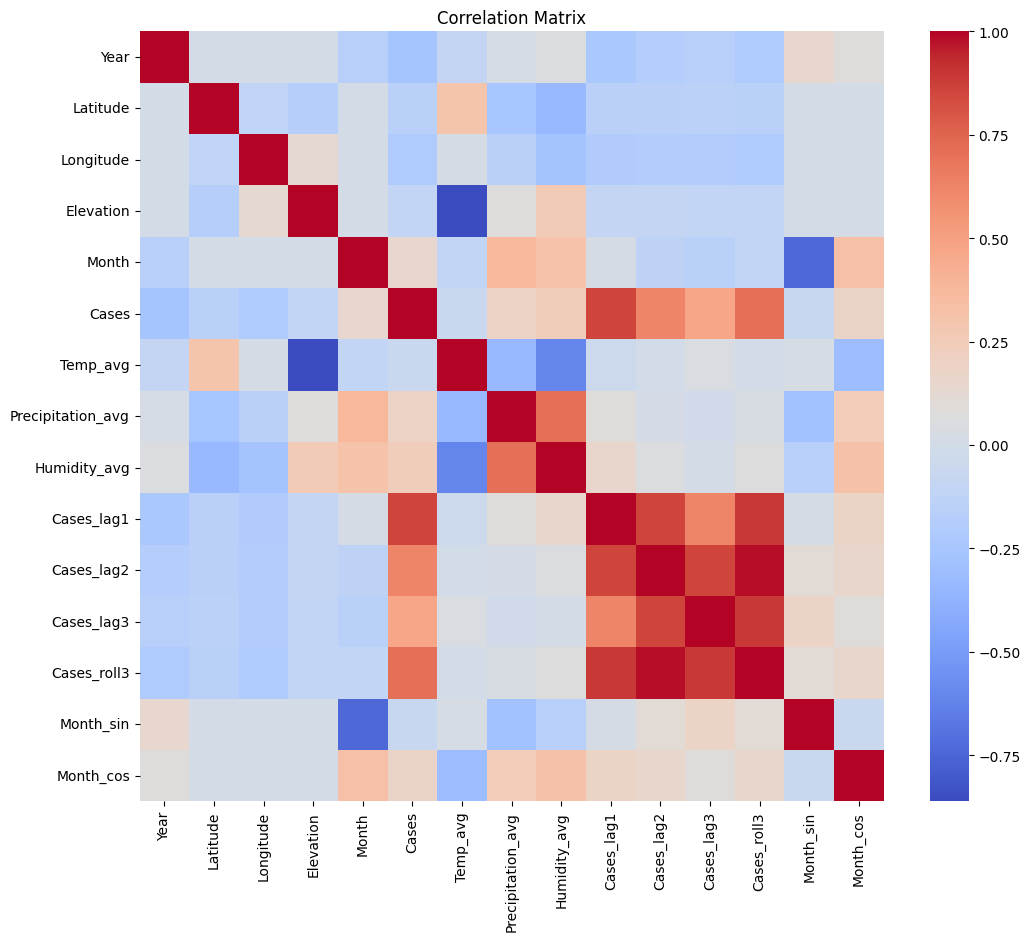


Correlation with Cases:

Cases                1.000000
Cases_lag1           0.857115
Cases_roll3          0.704619
Cases_lag2           0.624114
Cases_lag3           0.470124
Humidity_avg         0.232476
Precipitation_avg    0.186960
Month_cos            0.174766
Month                0.145454
Temp_avg            -0.061419
Month_sin           -0.072675
Elevation           -0.098312
Latitude            -0.157773
Longitude           -0.210515
Year                -0.259389
Name: Cases, dtype: float64


In [37]:
# Correlation Analysis (Numeric Only)
import seaborn as sns

numeric_df = df.select_dtypes(include=np.number)

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Correlation with target
corr_with_target = corr_matrix["Cases"].sort_values(ascending=False)
print("\nCorrelation with Cases:\n")
print(corr_with_target)

In [38]:
# Define Features and Target
TARGET = "Cases"

feature_cols = [
    "Province", "District",              # categorical
    "Latitude", "Longitude", "Elevation", # geo (numeric)
    "Temp_avg", "Precipitation_avg", "Humidity_avg", # weather (numeric)
    "Cases_lag1", "Cases_lag2", "Cases_lag3", "Cases_roll3", # engineered
    "Month_sin", "Month_cos"             # seasonality
]

X = df[feature_cols].copy()
y = df[TARGET].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (825, 14)
y shape: (825,)


In [39]:
# Time-based Train/Test Split
train_mask = df["Year"] < 2021
test_mask  = df["Year"] == 2021

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train years:", df.loc[train_mask, "Year"].unique())
print("Test years:", df.loc[test_mask, "Year"].unique())

Train: (525, 14)  Test: (300, 14)
Train years: [2019 2020]
Test years: [2021]


In [40]:
# Preprocessing Pipeline
categorical_features = ["Province", "District"]
numeric_features = [c for c in feature_cols if c not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="drop"
)

print(" Preprocessor ready")

 Preprocessor ready


In [43]:
# Metrics Function
def regression_metrics(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100  # avoid /0

    print(f"\n {label} Results")
    print(f"MAE : {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²  : {r2:.3f}")

    return {"Model": label, "MAE": mae, "RMSE": rmse, "R2": r2}

In [44]:
# Baseline - Linear Regression
lr_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)
pred_lr = lr_model.predict(X_test)

baseline_results = regression_metrics(y_test, pred_lr, label="Linear Regression (Baseline)")


 Linear Regression (Baseline) Results
MAE : 79.013
RMSE: 142.394
R²  : 0.745


In [45]:
# XGBoost Regressor (Main Model)
xgb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        objective="reg:squarederror"
    ))
])

xgb_model.fit(X_train, y_train)
pred_xgb = xgb_model.predict(X_test)

xgb_results = regression_metrics(y_test, pred_xgb, label="XGBoost Regressor")


 XGBoost Regressor Results
MAE : 54.598
RMSE: 129.678
R²  : 0.789


In [46]:
# Comparison Table + Quick Plot
results_df = pd.DataFrame([baseline_results, xgb_results])
results_df.sort_values("RMSE")

,Model,MAE,RMSE,R2
1,XGBoost Regressor,54.597630,129.677756,0.788823
0,Linear Regression (Baseline),79.012738,142.393868,0.745377


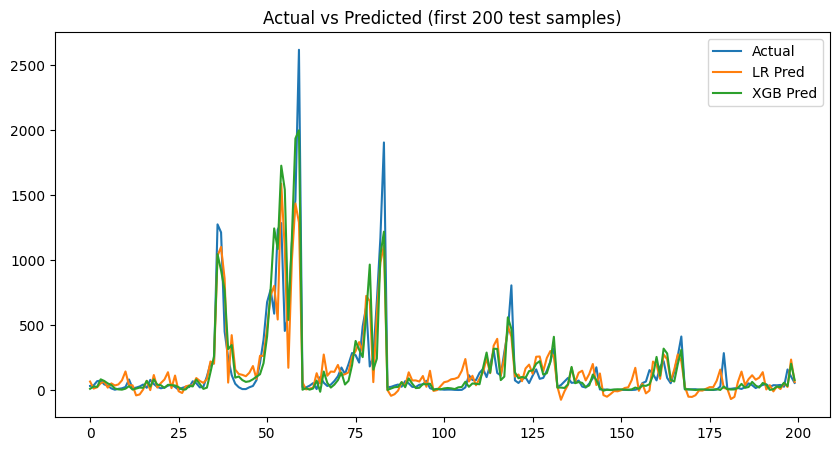

In [51]:
# Plot actual vs predicted (overall)
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:200], label="Actual")
plt.plot(pred_lr[:200], label="LR Pred")
plt.plot(pred_xgb[:200], label="XGB Pred")
plt.title("Actual vs Predicted (first 200 test samples)")
plt.legend()
plt.show()

In [53]:
# SHAP Explainability for XGBoost
# 1) Get trained internal parts
fitted_preprocess = xgb_model.named_steps["preprocess"]
fitted_xgb = xgb_model.named_steps["model"]

# 2) Transform X_test into model input space
X_test_trans = fitted_preprocess.transform(X_test)

# 3) Get feature names after OneHot + numeric
ohe = fitted_preprocess.named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([cat_names, np.array(numeric_features)])

# Convert to DataFrame (SHAP plots nicer)
X_test_trans_df = pd.DataFrame(X_test_trans, columns=all_feature_names)

# 4) SHAP explainer (tree-based, fast)
explainer = shap.TreeExplainer(fitted_xgb)
shap_values = explainer.shap_values(X_test_trans_df)

print("SHAP values computed:", np.array(shap_values).shape)

SHAP values computed: (300, 46)


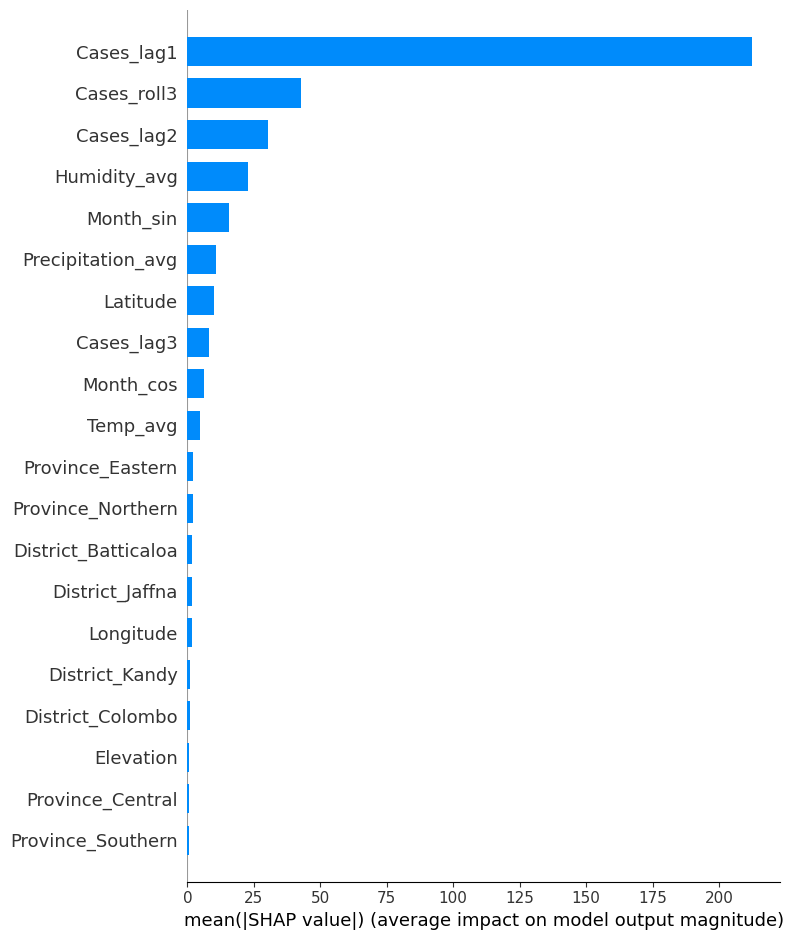

In [54]:
shap.summary_plot(shap_values, X_test_trans_df, plot_type="bar")

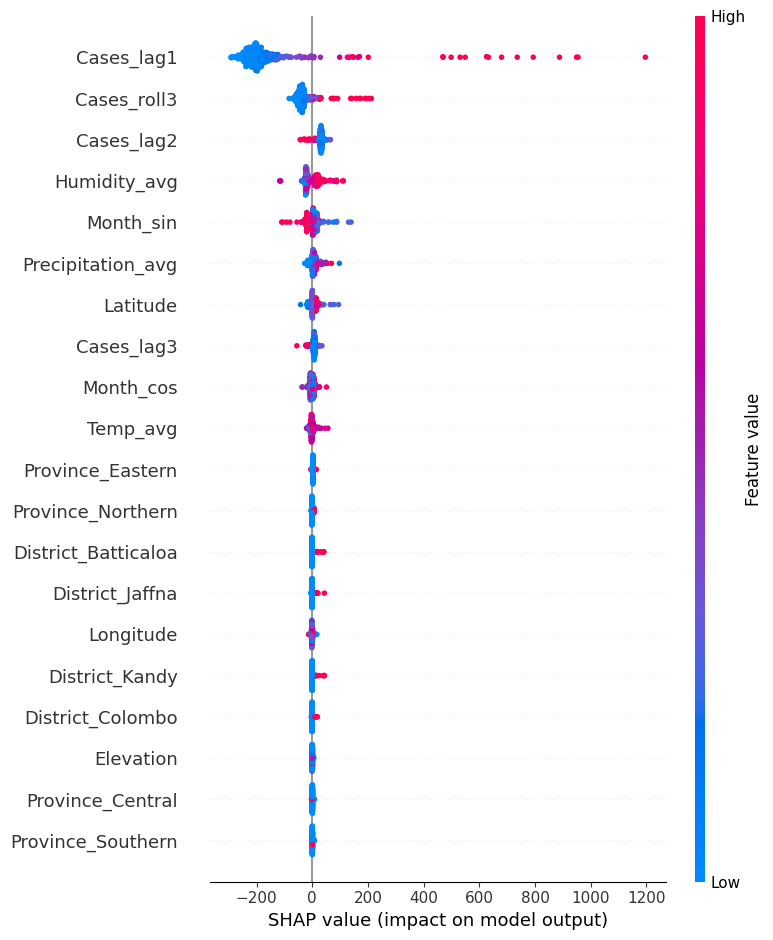

In [55]:
shap.summary_plot(shap_values, X_test_trans_df)

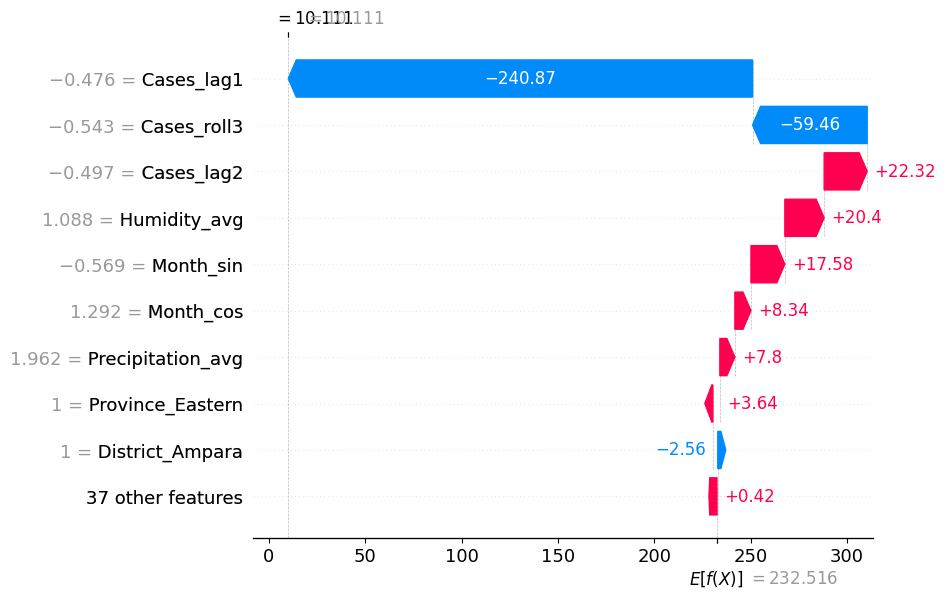

In [60]:
# Pick an example row
i = 10
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_test_trans_df.iloc[i],
        feature_names=all_feature_names
    )
)